trainX shape == (5571, 24, 17).
trainY shape == (5571, 1).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 64)            15936     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 25,377
Trainable params: 25,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
502/502 [==============================] - 21s 19ms/step - loss: 0.6131 - val_loss: 0.0497
Epoch 2/100
502/502 [=

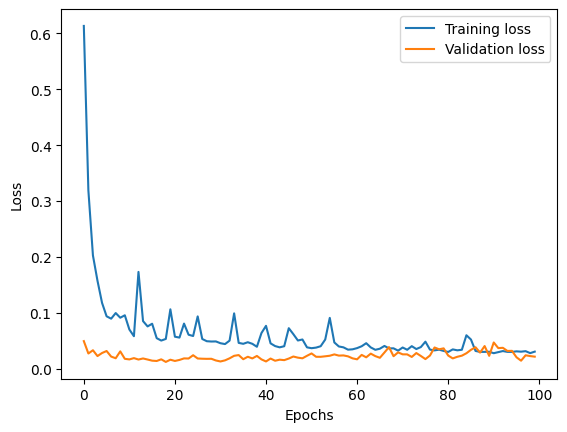

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2

file= './production/production.csv'

data=pd.read_csv(file)

grouped_data = data.groupby(['product_type','is_business','county'])

df = grouped_data.get_group((3,0,10))

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]



# Define the columns for training
cols = ['eic_count', 'installed_capacity', 'temperature', 'dewpoint',
        'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'windspeed_10m',
        'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
        'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
        'elect_prices', 'target']

# Initialize an empty DataFrame to store the scaled data
scaled_data = pd.DataFrame()

df_for_training = train_df[cols].astype(float)
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

trainX = []
trainY = []
n_future = 1  # Number of days we want to look into the future based on the past days.
n_past = 24 # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])  # Target column is the last one

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


model = Sequential()
model.add(GRU(64, activation='tanh', recurrent_activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(GRU(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_regularizer=l2(0.01)))  # Output dimension is 1 as we're predicting a single value

model.compile(optimizer='adam', loss='mse')
model.summary() 


history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.save('modelproduction.h5')



2/2 [==============================] - 3s 17ms/step


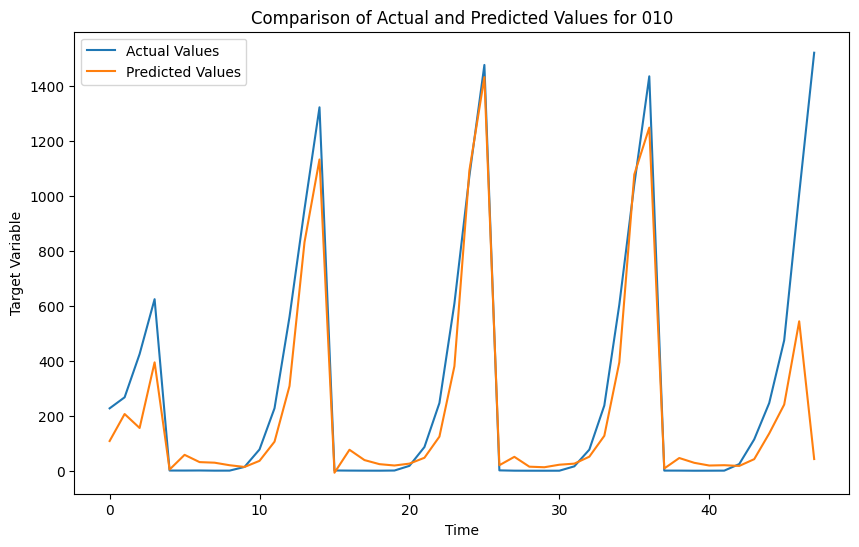

R2 Score: 0.7066459983753226
MSE: 61014.55876196139
RMSE: 247.01125229827363
MAE: 111.47363350423177



In [5]:
train_size = int(len(df) * 0.8)

test_df = df[train_size:]

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df_test = test_df[cols].astype(float)

# Use the scaler from the training to transform the test data
df_test_scaled1= scaler.fit(df_test)
df_test_scaled = scaler.transform(df_test)

# Initialize the lists for testX and testY
testX = []
testY = []


# Prepare testX and testY
for i in range(n_past, len(df_test_scaled) - n_future + 1):
    testX.append(df_test_scaled[i - n_past:i])
    testY.append(df_test_scaled[i + n_future - 1:i + n_future, -1])  # Assuming the last column is still the target

testX, testY = np.array(testX), np.array(testY)



n_days_for_prediction = 48



target_scaler = StandardScaler()
target_scaler.fit(df_test[['target']])


# Predict on the last n_days_for_prediction
prediction_scaled = model.predict(testX[-n_days_for_prediction:])
prediction = target_scaler.inverse_transform(prediction_scaled)
actual = target_scaler.inverse_transform(testY[-n_days_for_prediction:])


# Calculate the metrics
r2 = r2_score(actual, prediction)
mse = mean_squared_error(actual, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, prediction)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Values')
plt.plot(prediction, label='Predicted Values')
plt.title(f'Comparison of Actual and Predicted Values for 010')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()


print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}\n")

In [15]:
df1.columns

Index(['Unnamed: 0', 'datetime', 'product_type', 'county', 'eic_count',
       'installed_capacity', 'is_business', 'target', 'temperature',
       'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total',
       'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
       'direct_solar_radiation', 'diffuse_radiation', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'elect_prices', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'day'],
      dtype='object')

In [16]:
file1= './consumption/consommation.csv'

data1=pd.read_csv(file1)

grouped_data1 = data1.groupby(['product_type','is_business','county'])


df1 = grouped_data1.get_group((3,0,10))


In [18]:
df1.to_csv('consommation_client10.csv')
df.to_csv('production_client10.csv')

trainX shape == (5523, 72, 24).
trainY shape == (5523, 1).
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_44 (GRU)                (None, 72, 500)           789000    
                                                                 
 dropout_48 (Dropout)        (None, 72, 500)           0         
                                                                 
 lstm_6 (LSTM)               (None, 72, 400)           1441600   
                                                                 
 dropout_49 (Dropout)        (None, 72, 400)           0         
                                                                 
 gru_45 (GRU)                (None, 72, 300)           631800    
                                                                 
 dropout_50 (Dropout)        (None, 72, 300)           0         
                                                            

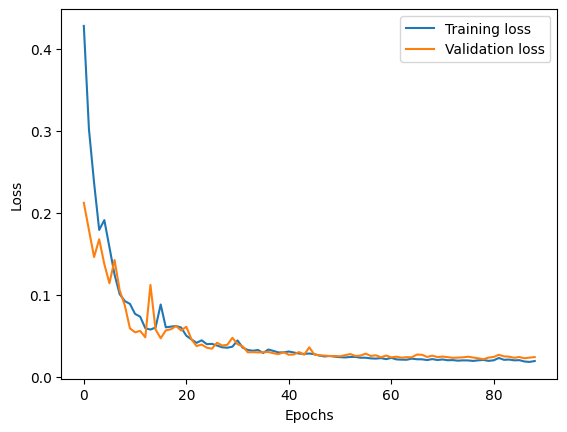

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization, LSTM
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define the columns for training
cols = ['eic_count', 'installed_capacity', 'temperature', 'dewpoint',
        'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'windspeed_10m',
        'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
        'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
        'elect_prices','hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'day', 'target']


train_size = int(len(df1) * 0.8)
train_df1 = df1[:train_size]
test_df1 = df1[train_size:]

scaled_data = pd.DataFrame()


df_for_training = train_df1[cols].astype(float)
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

n_future = 1  # Number of days we want to look into the future based on the past days.
n_past = 72 # Number of past days we want to use to predict the future.

trainX, trainY = [], []

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])  # Target column is the last one

trainX, trainY = np.array(trainX), np.array(trainY)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

print(f'trainX shape == {trainX.shape}.')
print(f'trainY shape == {trainY.shape}.')

# Model Building
model2 = Sequential()
model2.add(GRU(500, activation='tanh', recurrent_activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(400, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(GRU(300, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(GRU(50, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(1, kernel_regularizer=l2(0.001)))  # Output dimension is 1 as we're predicting a single value

model2.compile(optimizer='adam', loss='mse')
model2.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Model Training
history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[early_stop, reduce_lr])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 6s 66ms/step


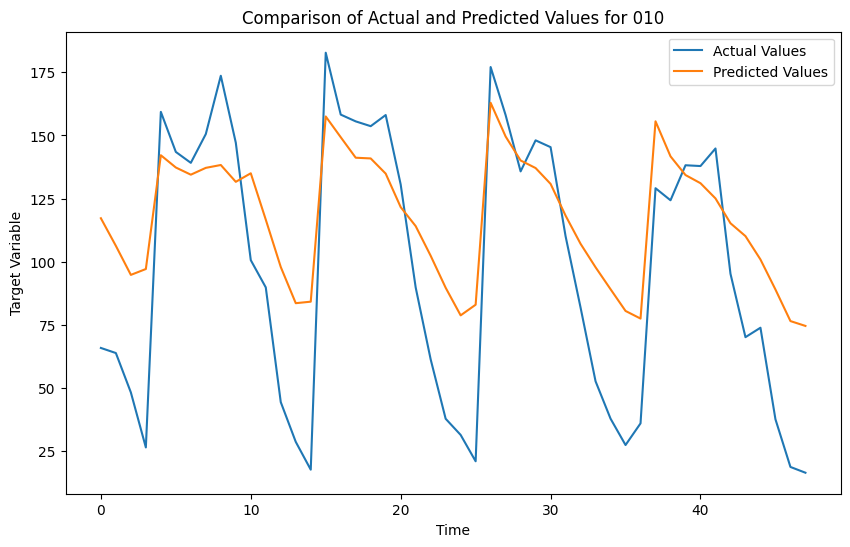

R2 Score: 0.5381255947814059
MSE: 1306.7198990452118
RMSE: 36.14858087180203
MAE: 30.536588985443117



In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df_test = test_df1[cols].astype(float)

# Use the scaler from the training to transform the test data
df_test_scaled1= scaler.fit(df_test)
df_test_scaled = scaler.transform(df_test)

# Initialize the lists for testX and testY
testX = []
testY = []


# Prepare testX and testY
for i in range(n_past, len(df_test_scaled) - n_future + 1):
    testX.append(df_test_scaled[i - n_past:i])
    testY.append(df_test_scaled[i + n_future - 1:i + n_future, -1])  # Assuming the last column is still the target

testX, testY = np.array(testX), np.array(testY)



n_days_for_prediction = 48



target_scaler = StandardScaler()
target_scaler.fit(df_test[['target']])


# Predict on the last n_days_for_prediction
prediction_scaled = model2.predict(testX[-n_days_for_prediction:])
prediction = target_scaler.inverse_transform(prediction_scaled)
actual = target_scaler.inverse_transform(testY[-n_days_for_prediction:])


# Calculate the metrics
r2 = r2_score(actual, prediction)
mse = mean_squared_error(actual, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, prediction)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Values')
plt.plot(prediction, label='Predicted Values')
plt.title(f'Comparison of Actual and Predicted Values for 010')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()


print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}\n")